In [ ]:
import pandas, warnings

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

plt.style.use("seaborn-whitegrid")

from statsmodels.tools.sm_exceptions import ValueWarning

warnings.simplefilter('ignore', ValueWarning)

!pip install pmdarima --quiet

In [ ]:
url = "/content/supernoprofit.csv"

origin = pandas.read_table(url, sep=",", parse_dates=["order_date"])

origin.iloc[:5]

,order_date,sales
0,2017-11-08,261.9600
1,2017-11-08,731.9400
2,2017-06-12,14.6200
3,2016-10-11,957.5775
4,2016-10-11,22.3680


In [ ]:
origin.tail()

,order_date,sales
9795,2017-05-21,3.798
9796,2016-01-12,10.368
9797,2016-01-12,235.188
9798,2016-01-12,26.376
9799,2016-01-12,10.384


In [ ]:
origin.isnull().sum().sum()

0

In [ ]:
origin = origin.sort_values("order_date").set_index("order_date")

origin.iloc[:5]

,sales
order_date,
2015-01-03,16.448
2015-01-04,3.540
2015-01-04,272.736
2015-01-04,11.784
2015-01-05,19.536


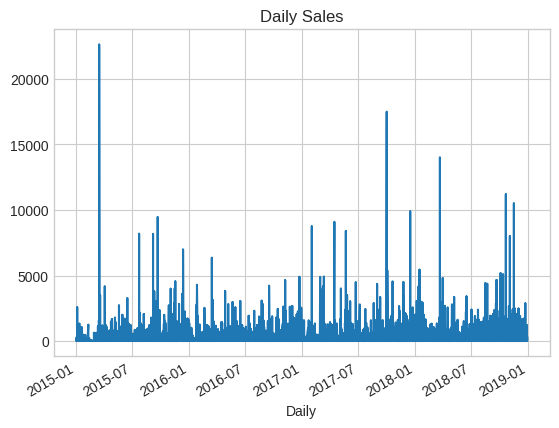

In [ ]:
plot = origin.sales.plot(title="Daily Sales", xlabel="Daily", y="Total Sales");

In [ ]:
daily = origin.resample("D").mean()

daily.isnull().sum().sum()

228

In [ ]:
daily = daily.interpolate(method="linear")

daily.isnull().sum().sum()

0

In [ ]:
from statsmodels.tsa.stattools import adfuller

adfullertest = adfuller(daily)

len(adfullertest)

6

In [ ]:
alpha = 0.05

result_one = adfullertest[1] < alpha

result_one

True

In [ ]:
upper = adfullertest[0]

for val in adfullertest[4].values():
  if upper > val:
    result_two = False
    break
  result_two = True

result_two

True

In [ ]:
from pmdarima.arima import ADFTest

adftest = ADFTest(alpha=alpha)

adftest.should_diff(daily)

(0.01, False)

In [ ]:
result_three = adftest.should_diff(daily)[1]

result_three

False

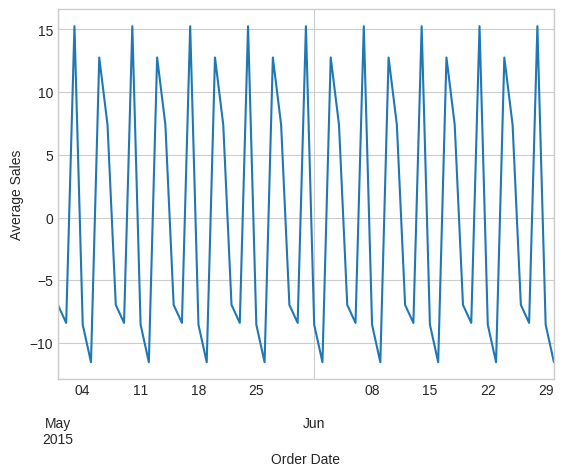

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(daily)

seasonal = decomposition.seasonal.loc["2015-05":"2015-06"].plot(xlabel="Order Date", ylabel="Average Sales");

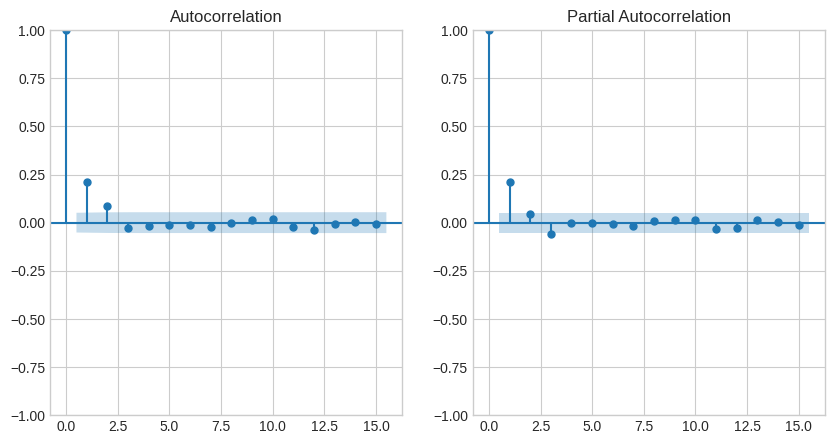

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

cate, axes = plt.subplots(1, 2, figsize=(10, 5))

plot_acf(daily, lags=15, ax=axes[0])

plot_pacf(daily, lags=15, ax=axes[1]);

In [ ]:
orders = [(2, 0, 1), (1, 0, 1), (1, 0, 2), (2,0,2)]

len(daily)

1458

In [ ]:
train_split = daily[:1450]

test_split = daily[1450:]

len(train_split), len(test_split)

(1450, 8)

### `Model 1`

In [ ]:
import numpy as np

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error

result = {}

for order in orders:

  model = ARIMA(train_split, order=order).fit()

  logits = model.forecast(len(test_split))

  errors = np.sqrt(mean_squared_error(test_split, logits))

  result[str(order)] = round(errors, 3)

pandas.DataFrame(result, index=["RMSE"]).T.sort_values("RMSE")

,RMSE
"(2, 0, 2)",111.376
"(1, 0, 1)",112.193
"(1, 0, 2)",112.281
"(2, 0, 1)",113.246


In [ ]:
model = ARIMA(train_split, order=(2, 0, 2)).fit()

logits = model.forecast(len(test_split))

errors = np.sqrt(mean_squared_error(test_split, logits))

errors

111.37601072617444

In [ ]:
test_split.join(logits)

,sales,predicted_mean
order_date,,
2018-12-23,128.451733,239.819774
2018-12-24,389.565875,233.561139
2018-12-25,117.344652,220.942972
2018-12-26,203.648500,221.306377
2018-12-27,88.818000,223.010932
2018-12-28,87.228989,223.026438
2018-12-29,242.961167,222.798607
2018-12-30,101.970000,222.787948


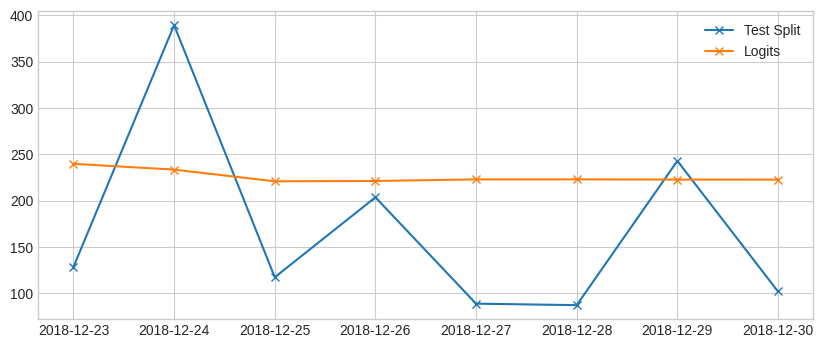

In [ ]:
def testplot(test_split, logits):

  cate, ax = plt.subplots(figsize=(10, 4))

  ax.plot(test_split, label="Test Split", marker="x")

  ax.plot(logits, label="Logits", marker="x")

  ax.legend()

testplot(test_split, logits)

### `Model 2`

In [ ]:
import pmdarima as pm

ontrue = !False

model_auto = pm.auto_arima(
  train_split,
  seasonal=ontrue, m=12,
  trace=False, test="adf",
  start_p=0, start_q=0,
  error_action="ignore",
  suppress_warnings=ontrue,
  stepwise=ontrue
)

In [ ]:
model_auto.get_params().get("order")

(3, 0, 0)

In [ ]:
model_auto.get_params().get("seasonal_order")

(0, 0, 0, 12)

In [ ]:
model = ARIMA(train_split, order=model_auto.get_params().get("order")).fit()

logits = model.forecast(len(test_split))

errors = np.sqrt(mean_squared_error(test_split, logits))

errors

111.93498032774929

### `Model 3`

In [ ]:
import statsmodels.api as sm

model = sm.tsa.statespace.SARIMAX(
  train_split,
  order=(2, 0, 2),
  seasonal_order=(1, 1, 0, 12)
).fit()

logits = model.forecast(len(test_split))

errors = np.sqrt(mean_squared_error(test_split, logits))

In [ ]:
errors

65.79877624305327

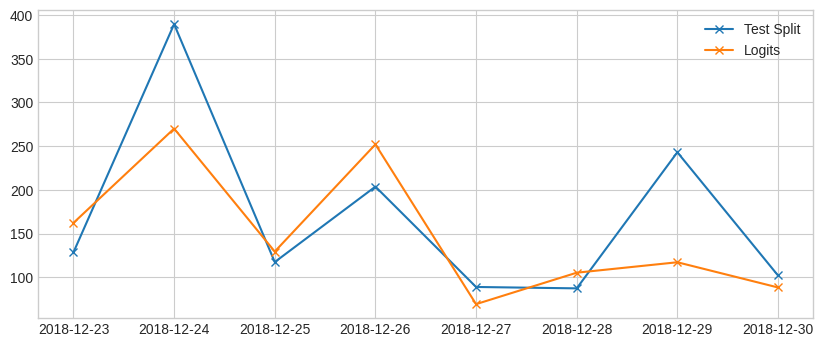

In [ ]:
testplot(test_split, logits)

In [ ]:
test_split.join(logits)

,sales,predicted_mean
order_date,,
2018-12-23,128.451733,162.152166
2018-12-24,389.565875,270.049383
2018-12-25,117.344652,129.333141
2018-12-26,203.648500,251.984728
2018-12-27,88.818000,69.174344
2018-12-28,87.228989,105.150972
2018-12-29,242.961167,117.102547
2018-12-30,101.970000,88.246187
